In [1]:
import numpy as np
import pandas
from matplotlib import pyplot as plt
import os
import glob
import pymc
import kabuki
import hddm
plt.rcParams['figure.figsize'] = [8, 8]

% matplotlib notebook

def plot_invlogit_z(model):
    plt.figure()
    xx = pymc.invlogit(pymc.invlogit(model.get_group_traces()['z_Intercept_trans']))
    plt.subplot(1, 2, 1)
    plt.plot(xx)
    plt.subplot(1, 2, 2)
    plt.hist(xx, 30)
    
    
def get_dic(hddmModel):
    '''
    compute devianceBar - deviance(thetaBar)
    '''

    mcModel = hddmModel.mc
    db = mcModel.db
    # get the expected value of the deviance
    devianceBar = np.mean(db.trace('deviance')())

    # need to evaluate deviance at "best" posterior estimate
    for stochastic in mcModel.stochastics:
        try:
            traces = stochastic.trace()
            if ('trans' in stochastic.__name__):
                # because these are apparently double transformed
                bestValue = np.mean(pymc.invlogit(pymc.invlogit(traces)))
            else:
                bestValue = np.mean(traces)

            stochastic.value = bestValue

        except KeyError:
            print('No trace available for {:s}'.format(stochastic.__name__))

    dic = 2*devianceBar - mcModel.deviance 

    return dic


def get_dic(hddmModel):
    '''
    compute devianceBar - deviance(thetaBar)
    '''

    mcModel = hddmModel.mc
    db = mcModel.db
    # get the expected value of the deviance
    devianceBar = np.mean(db.trace('deviance')())

    # need to evaluate deviance at "best" posterior estimate
    for stochastic in mcModel.stochastics:
        try:
            traces = stochastic.trace()
            if ('trans' in stochastic.__name__):
                # because these are apparently double transformed
                bestValue = np.mean(pymc.invlogit(pymc.invlogit(traces)))
            else:
                bestValue = np.mean(traces)

            stochastic.value = bestValue

        except KeyError:
            print('No trace available for {:s}'.format(stochastic.__name__))

    dic = 2*devianceBar - mcModel.deviance 

    return dic 


def load_models(modelNames):
    modelList = []
    for m in modelNames:
        print(m)
        modelList.append(hddm.load(m))
    
    rHat_modelList = kabuki.analyze.gelman_rubin(modelList)
    for k in rHat_modelList.keys():
        if (rHat_modelList[k] > 1.05 or rHat_modelList[k] < 0.95):
            print('RHat value warning: {:s}: {:f}'.format(k, rHat_modelList[k]))
    
    concatModel = kabuki.utils.concat_models(modelList)

    return concatModel, get_dic(concatModel)


def get_model_path(task, congruenceList):
    params = ['v', 'zS', 'a', 't']
    congruenceStrList = []
    for p in params:
        if p in congruenceList or (p == 'zS' and 'z' in congruenceList):
            congruenceStrList.append(p + 'C')
        else:
            congruenceStrList.append(p)
    congruenceStr = '_'.join(congruenceStrList)
    resDir = task + '_all_accuracy_{:s}'.format(congruenceStr)
    modelPaths = glob.glob(os.path.join(resDir, 'model*.pkl'))
            
    return resDir, modelPaths 


def plot_and_export_traces(task, congParamList):
    incong = 'C(condition, Treatment("control"))[T.incongruent]' 
    cong = 'C(condition, Treatment("control"))[T.congruent]'
    resultDir, modelPaths = get_model_path(task, congParamList)
    m, dic = load_models(modelPaths)
    print(task, congParamList, 'dic: ', dic)
    m.plot_posteriors()
    print('Exporting...')
    if len(congParamList) > 0:
        exportFilename = task + '_' + '_'.join(congParamList) + '_concatenated_traces.csv'
    else:
        exportFilename = task + '_null_concatenated_traces.csv'
        
    tr = m.get_group_traces()
    tr.rename(columns=lambda x: x.replace(incong, '_incongruent'),
              inplace=True)
    tr.rename(columns=lambda x: x.replace(cong, '_congruent'),
              inplace=True) 
    tr.to_csv(exportFilename, header=True, index=False)
            
    return m


def plot_effects(model):
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.figure()
    param = 'v'
    intercept = model.get_group_traces()[param + '_Intercept']
    try:
        congruent = intercept + model.get_group_traces()[param + '_C(condition, Treatment("control"))[T.congruent]']
    except:
        congruent = []
    try:
        incongruent = intercept + model.get_group_traces()[param + '_C(condition, Treatment("control"))[T.incongruent]']
    except:
        incongruent = []
    plt.subplot(3, 3, 1)
    plt.hist(intercept, 100)
    plt.xlim(0, 3)
    plt.title(param + ', No modulation')
    plt.subplot(3, 3, 4)
    plt.hist(congruent, 100, color='g')
    plt.xlim(0, 3)
    plt.title(param + ', Congruent')
    plt.subplot(3, 3, 7)
    plt.hist(incongruent, 100, color='r')
    plt.xlim(0, 3)
    plt.title(param + ', Incongruent')

    param = 'a'
    intercept = model.get_group_traces()[param + '_Intercept']
    try:
        congruent = intercept + model.get_group_traces()[param + '_C(condition, Treatment("control"))[T.congruent]']
    except:
        congruent = []
    try:
        incongruent = intercept + model.get_group_traces()[param + '_C(condition, Treatment("control"))[T.incongruent]']
    except:
        incongruent = []
    plt.subplot(3, 3, 2)
    plt.hist(intercept, 100)
    plt.xlim(0.5, 1.75)
    plt.title(param + ', No Modulation')
    plt.subplot(3, 3, 5)
    plt.hist(congruent, 100, color='g')
    plt.xlim(0.5, 1.75)
    plt.title(param + ', Congruent')
    plt.subplot(3, 3, 8)
    plt.hist(incongruent, 100, color='r')
    plt.xlim(0.5, 1.75)
    plt.title(param + ', Incongruent')
    
    param = 'z'
    # because of link function silliness:
    intercept = pymc.invlogit(model.get_group_traces()[param + '_Intercept_trans'])
    try:
        congruent = intercept + model.get_group_traces()[param + '_C(condition, Treatment("control"))[T.congruent]']
    except:
        congruent = []
    try:
        incongruent = intercept + model.get_group_traces()[param + '_C(condition, Treatment("control"))[T.incongruent]']
    except:
        incongruent = []
    plt.subplot(3, 3, 3)
    plt.hist(pymc.invlogit(intercept), 100)
    plt.xlim(0.4, 0.6)
    plt.title(param + ', No modulation')
    plt.subplot(3, 3, 6)
    try:
        plt.hist(pymc.invlogit(congruent), 100, color='g')
    except:
        plt.hist([], 100, color='g')
    plt.xlim(0.4, 0.6)
    plt.title(param + ', Congruent')
    plt.subplot(3, 3, 9)
    try:
        plt.hist(pymc.invlogit(incongruent), 100, color='r')
    except:
        plt.hist([], 100, color='r')
    plt.xlim(0.4, 0.6)
    plt.title(param + ', Incongruent')
    
    plt.tight_layout()

/home/leonardv/virtualenvs/np/lib/python3.4/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


## Audio, v ~ congruence, a ~ congruence, z ~ congruence

audio_all_accuracy_vC_zSC_aC_t/model_1.pkl
audio_all_accuracy_vC_zSC_aC_t/model_2.pkl
audio_all_accuracy_vC_zSC_aC_t/model_3.pkl
audio_all_accuracy_vC_zSC_aC_t/model_4.pkl
audio_all_accuracy_vC_zSC_aC_t/model_5.pkl
audio ['v', 'a', 'z'] dic:  6075.38002767
Plotting sv


<IPython.core.display.Javascript object>


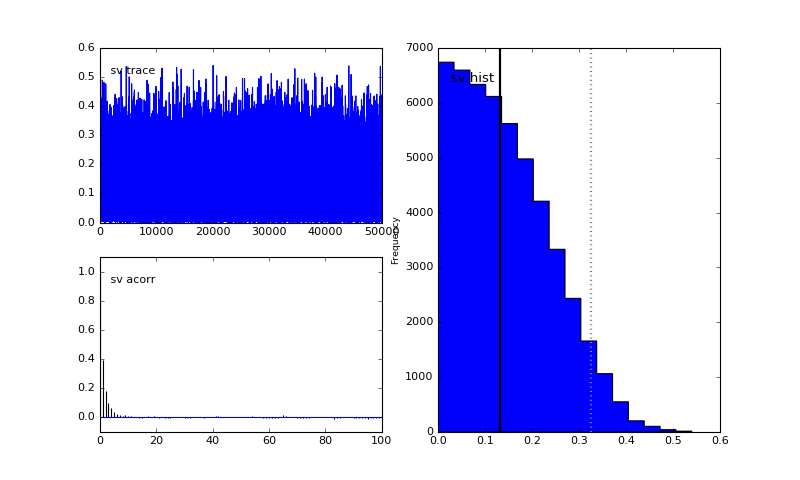

Plotting sz


<IPython.core.display.Javascript object>


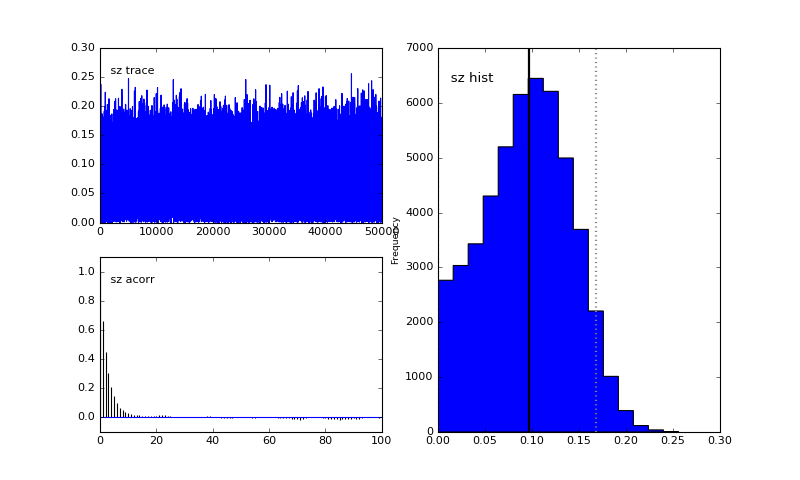

Plotting st


<IPython.core.display.Javascript object>


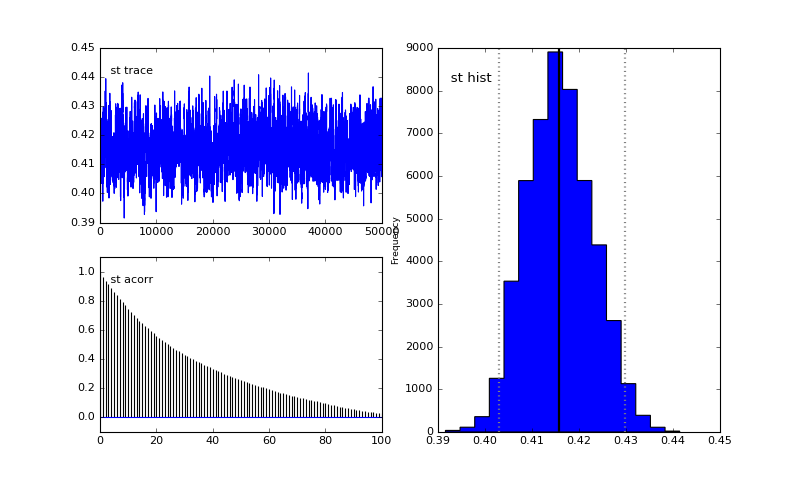

Plotting v_Intercept


<IPython.core.display.Javascript object>


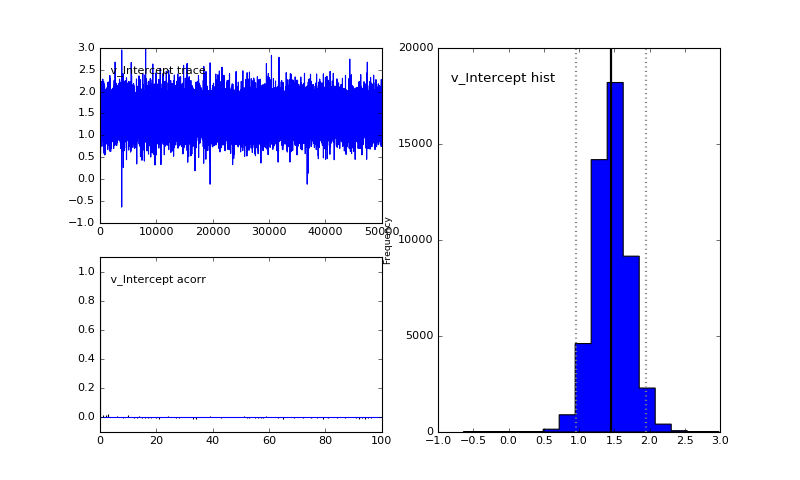

Plotting v_Intercept_std


<IPython.core.display.Javascript object>


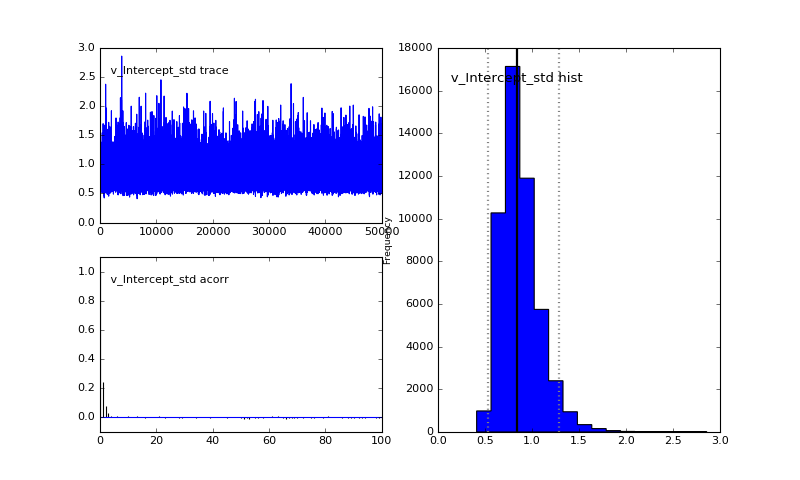

Plotting v_C(condition, Treatment("control"))[T.congruent]


<IPython.core.display.Javascript object>


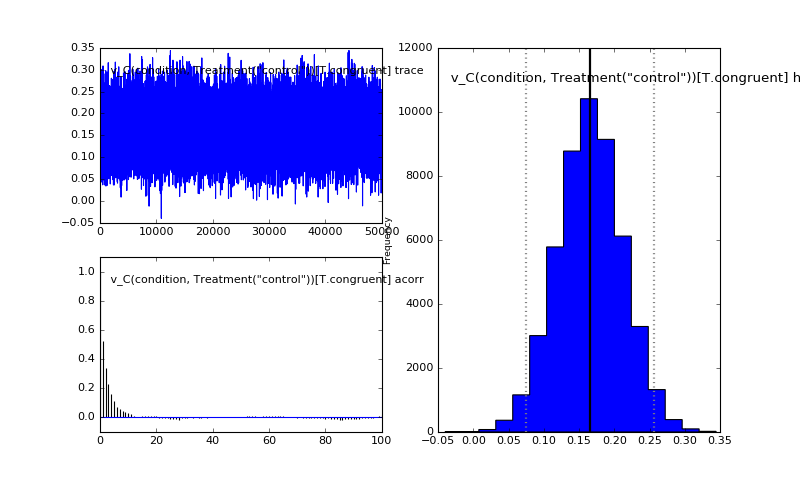

Plotting v_C(condition, Treatment("control"))[T.incongruent]


<IPython.core.display.Javascript object>


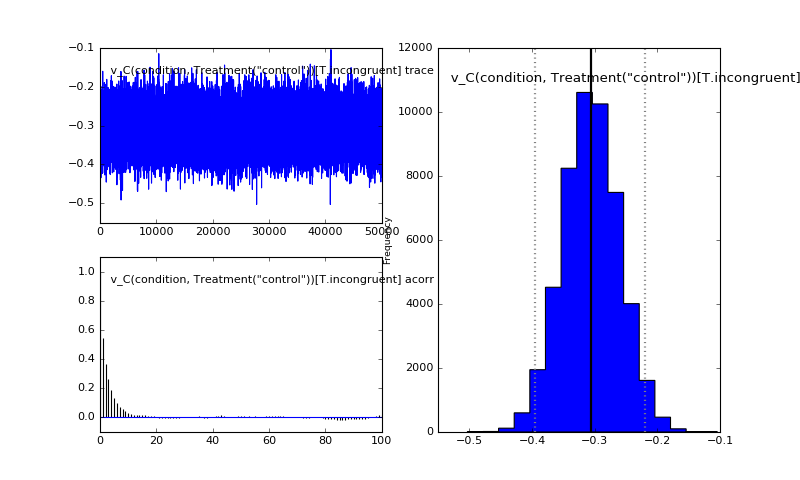

Plotting z_Intercept


<IPython.core.display.Javascript object>


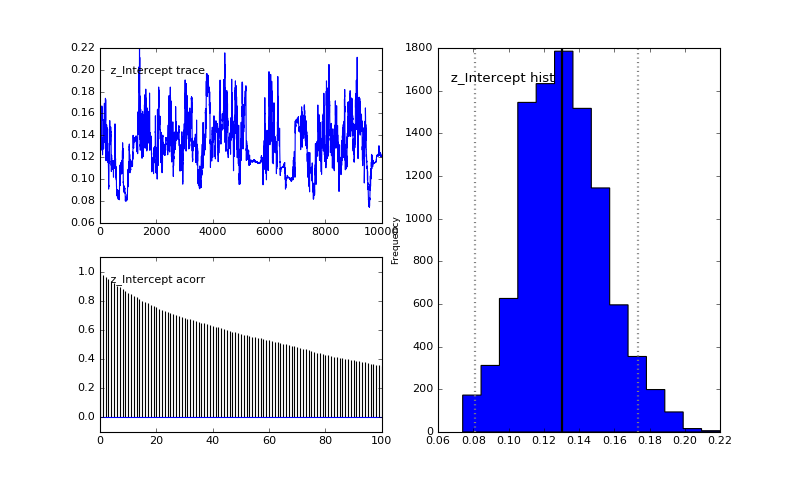

Plotting z_Intercept_std


<IPython.core.display.Javascript object>


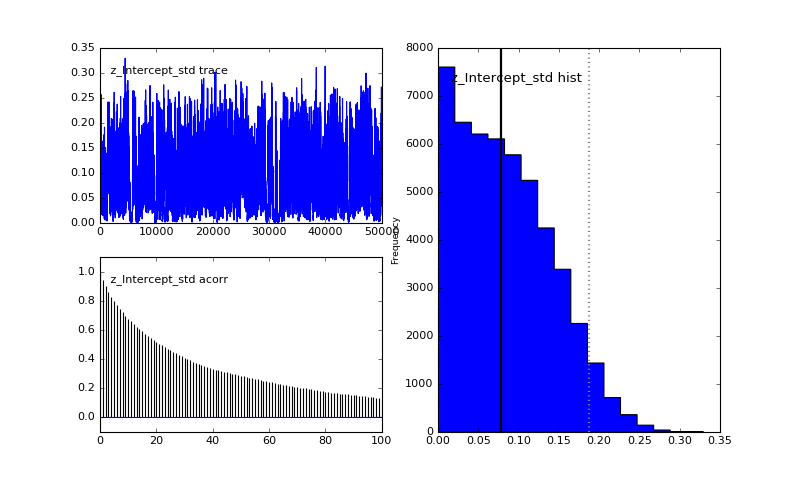

Plotting z_C(condition, Treatment("control"))[T.congruent]


<IPython.core.display.Javascript object>


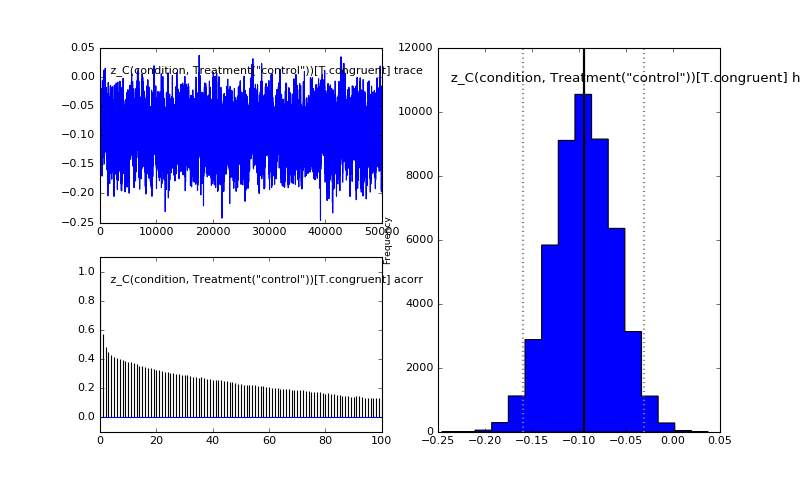

Plotting z_C(condition, Treatment("control"))[T.incongruent]


<IPython.core.display.Javascript object>


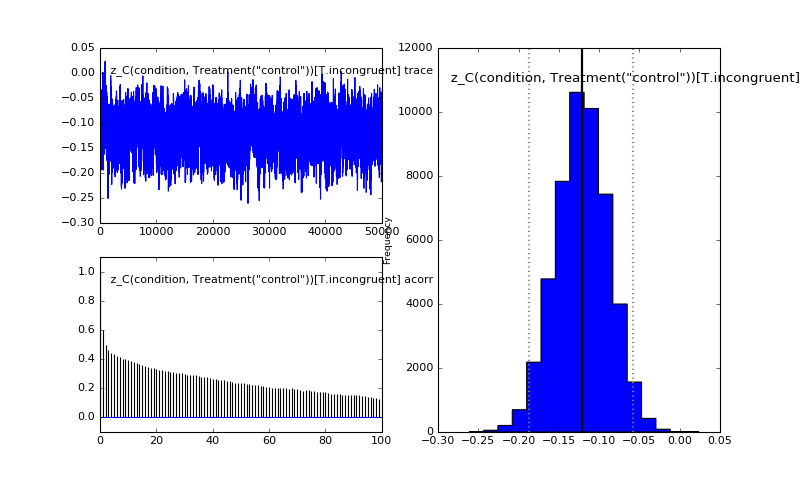

Plotting a_Intercept


<IPython.core.display.Javascript object>


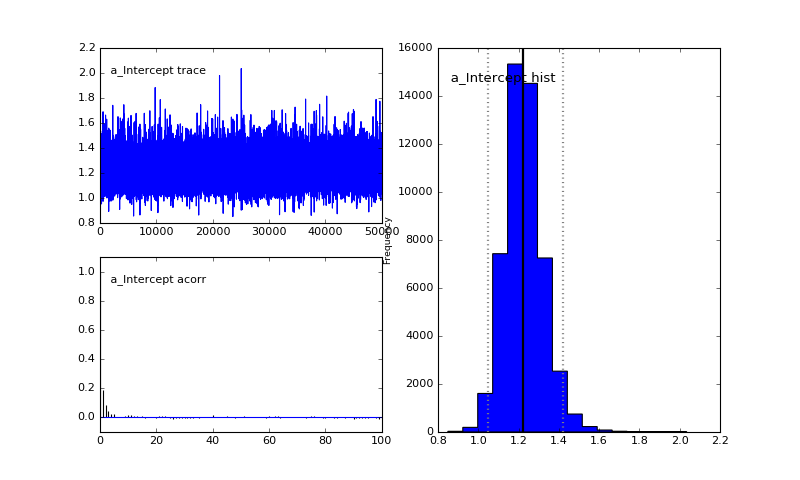

Plotting a_Intercept_std


<IPython.core.display.Javascript object>


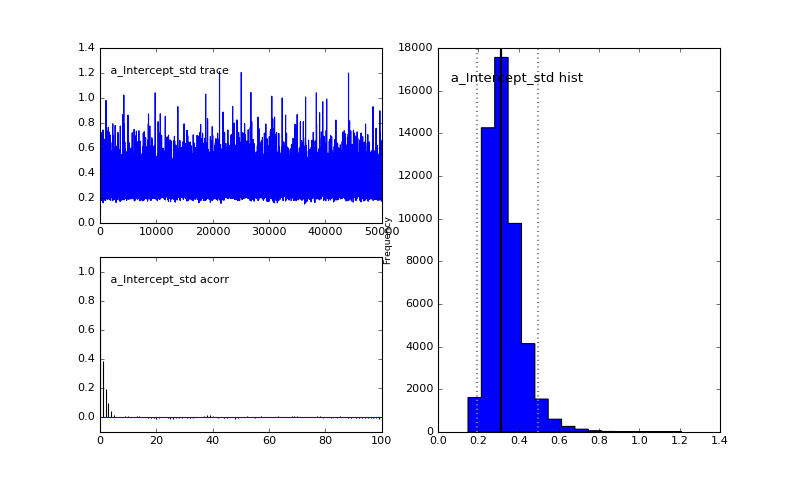

Plotting a_C(condition, Treatment("control"))[T.congruent]


<IPython.core.display.Javascript object>


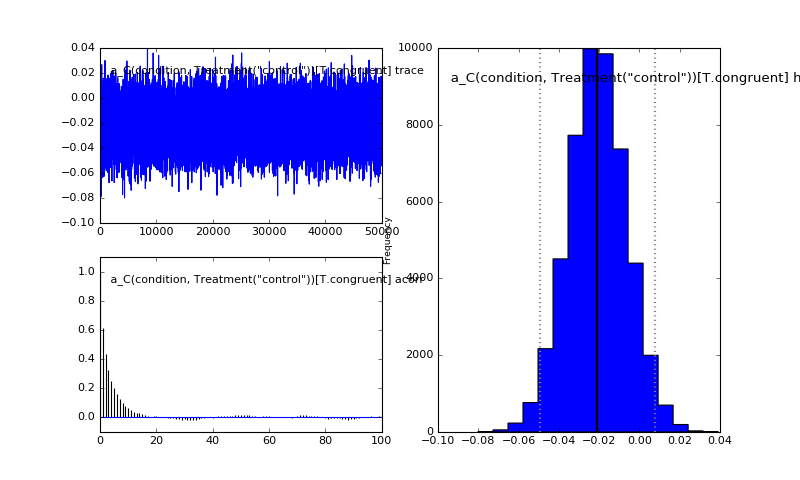

Plotting a_C(condition, Treatment("control"))[T.incongruent]


<IPython.core.display.Javascript object>


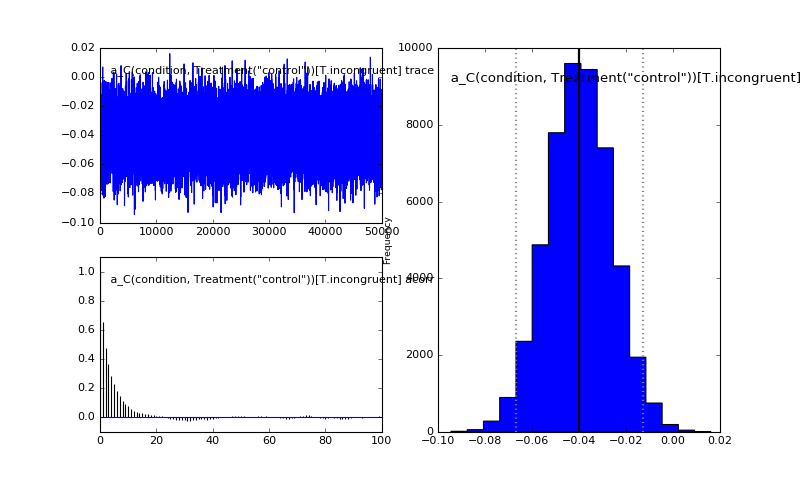

Plotting t_Intercept


<IPython.core.display.Javascript object>


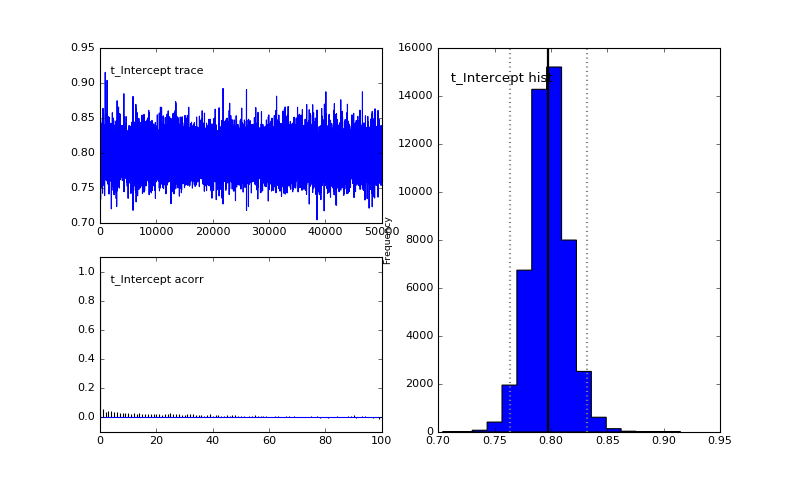

Plotting t_Intercept_std


<IPython.core.display.Javascript object>


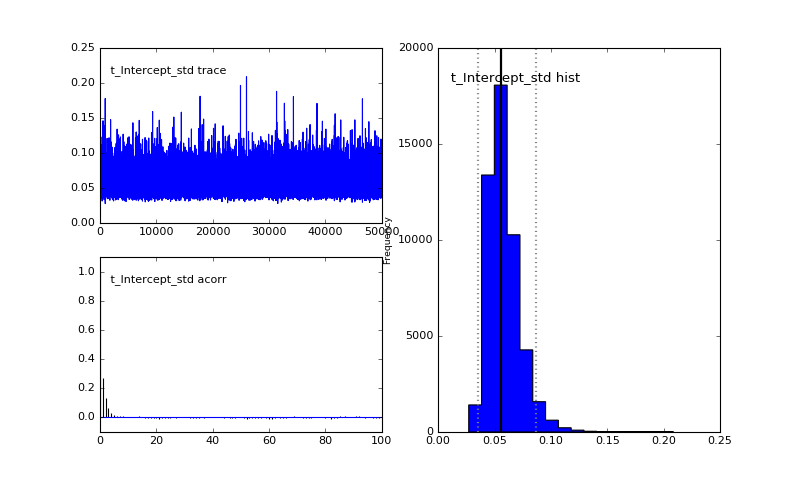

Exporting...


<IPython.core.display.Javascript object>


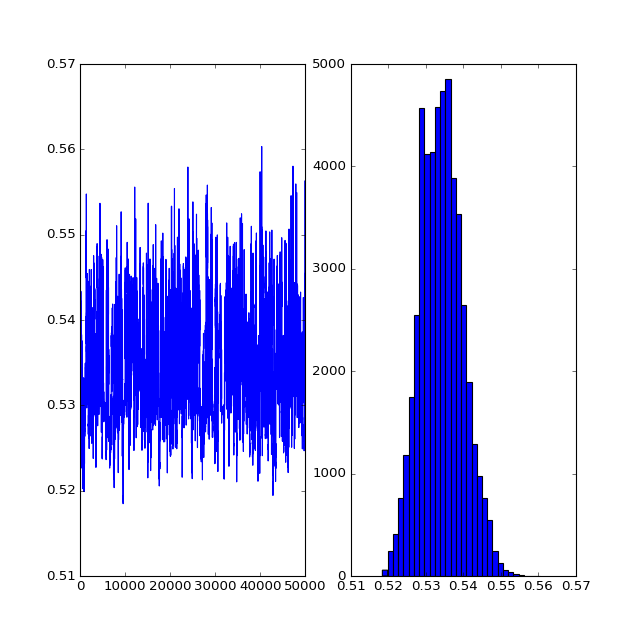

<IPython.core.display.Javascript object>


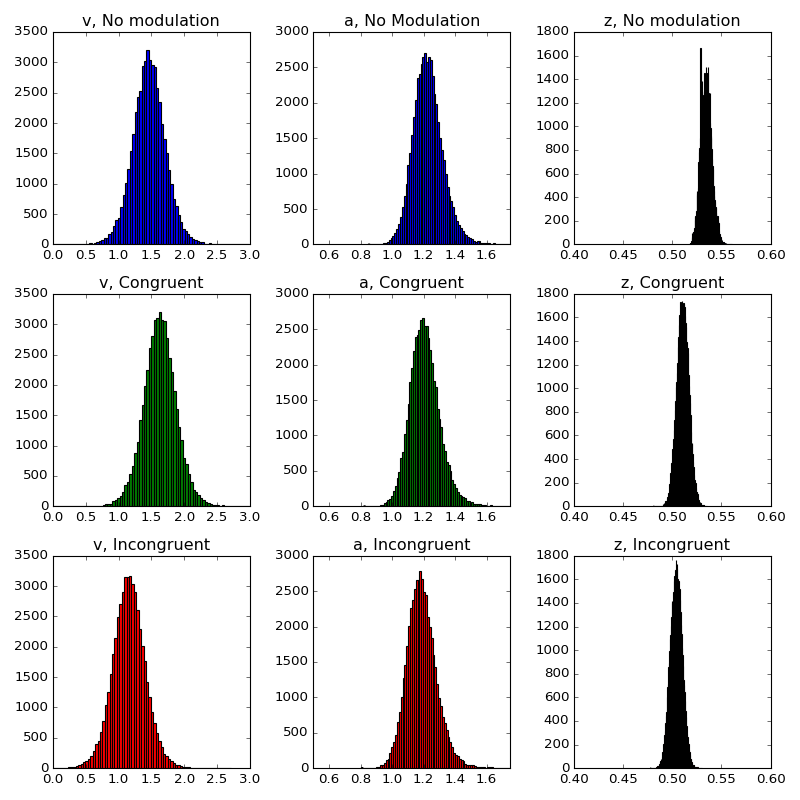

In [2]:
audio_v_a_z = plot_and_export_traces('audio', ['v', 'a', 'z'])
plot_invlogit_z(audio_v_a_z)
plot_effects(audio_v_a_z)

## Audio, no parameters dependent on congruence ("null") 

audio_all_accuracy_v_zS_a_t/model_1.pkl
audio_all_accuracy_v_zS_a_t/model_2.pkl
audio_all_accuracy_v_zS_a_t/model_3.pkl
audio_all_accuracy_v_zS_a_t/model_4.pkl
audio_all_accuracy_v_zS_a_t/model_5.pkl
audio [] dic:  5125.22497457
Plotting sv


<IPython.core.display.Javascript object>


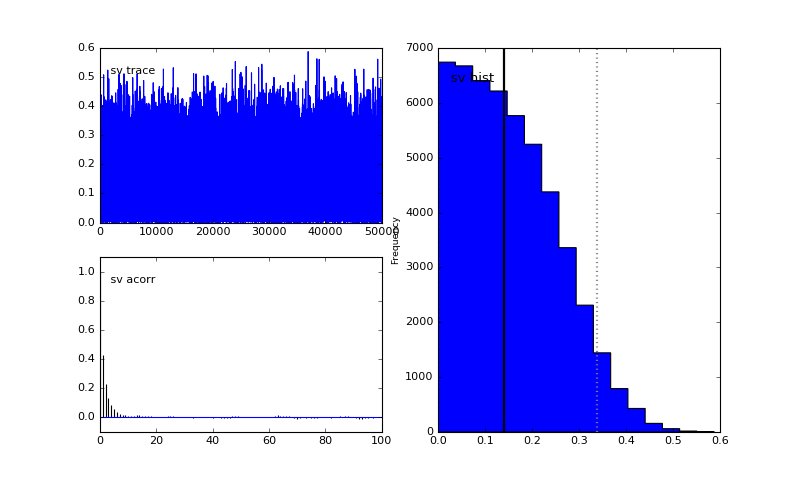

Plotting sz


/home/leonardv/virtualenvs/np/lib/python3.4/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


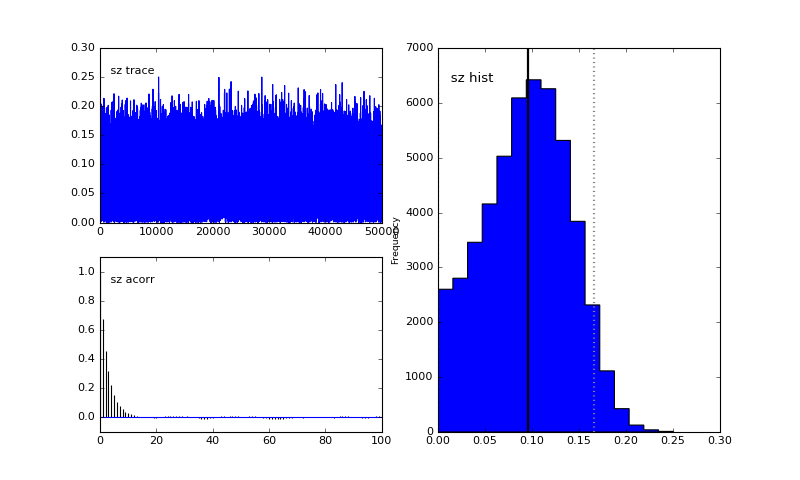

Plotting st


<IPython.core.display.Javascript object>


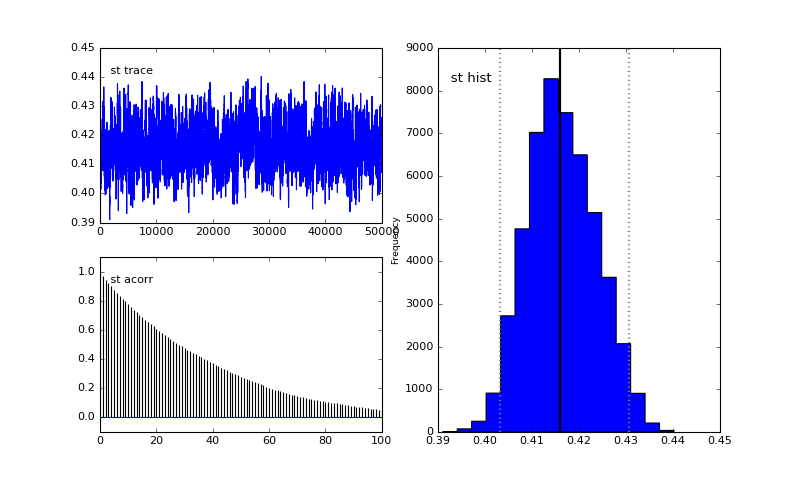

Plotting v_Intercept


<IPython.core.display.Javascript object>


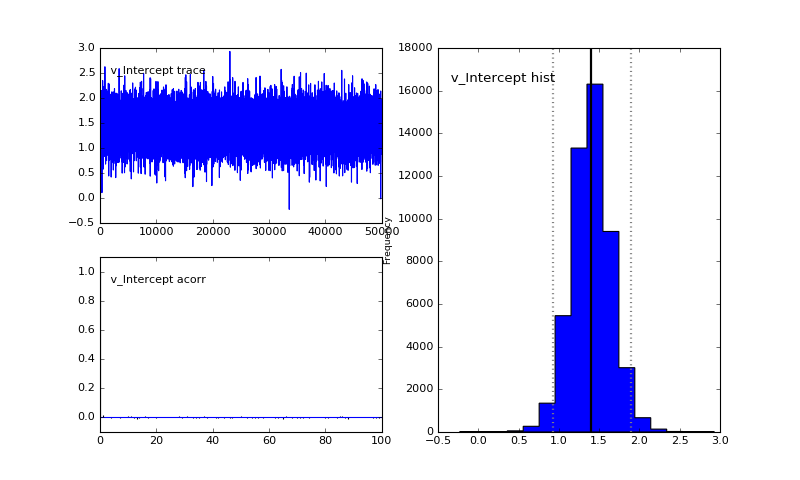

Plotting v_Intercept_std


<IPython.core.display.Javascript object>


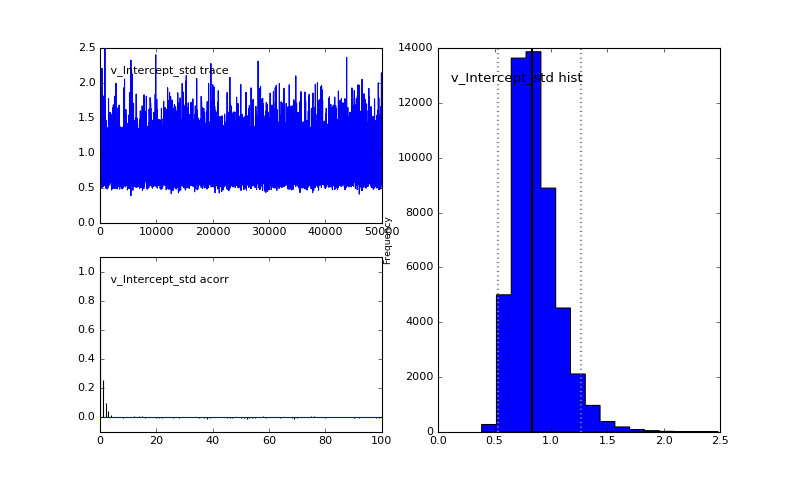

Plotting z_Intercept


<IPython.core.display.Javascript object>


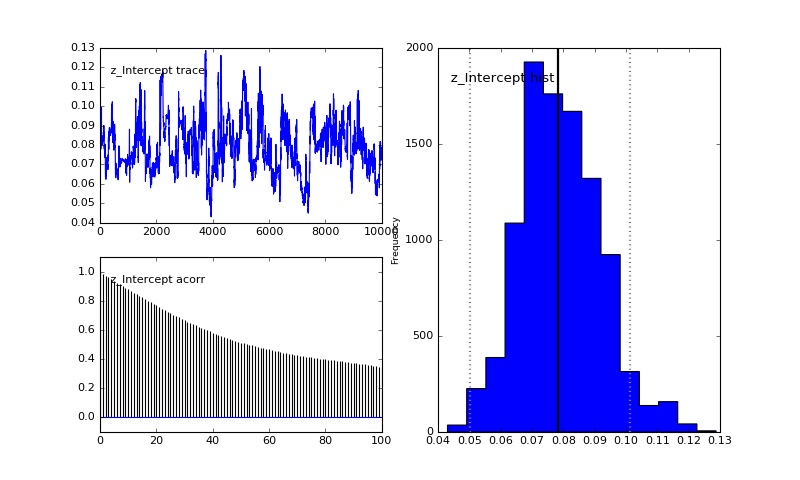

Plotting z_Intercept_std


<IPython.core.display.Javascript object>


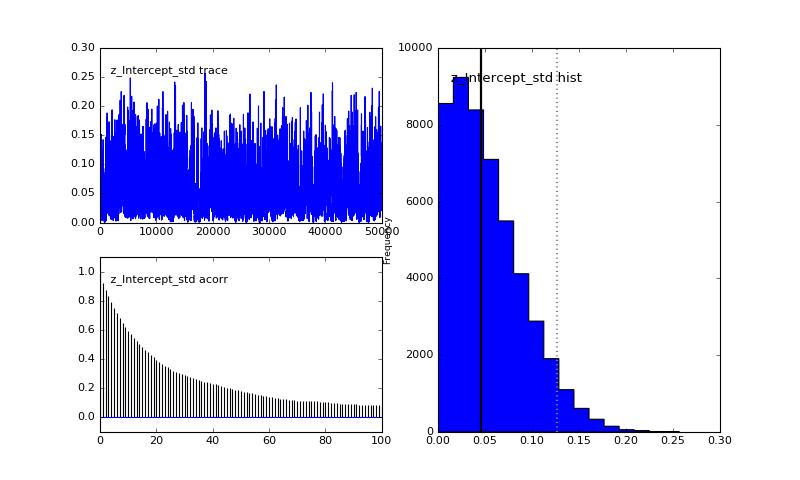

Plotting a_Intercept


<IPython.core.display.Javascript object>


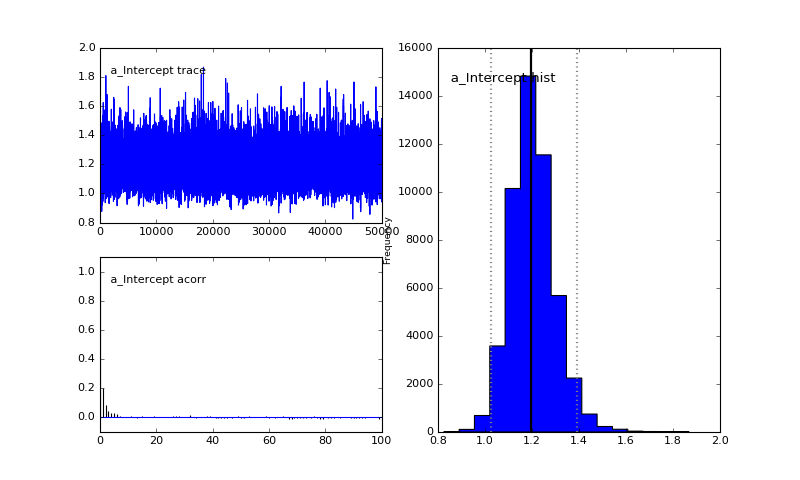

Plotting a_Intercept_std


<IPython.core.display.Javascript object>


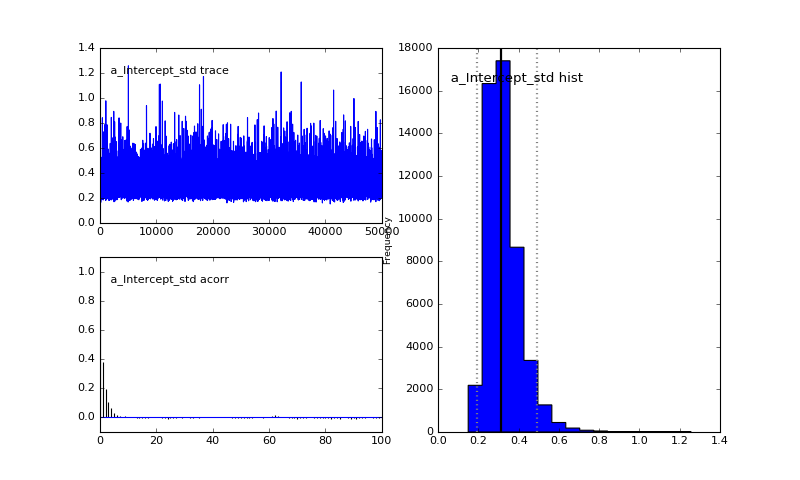

Plotting t_Intercept


<IPython.core.display.Javascript object>


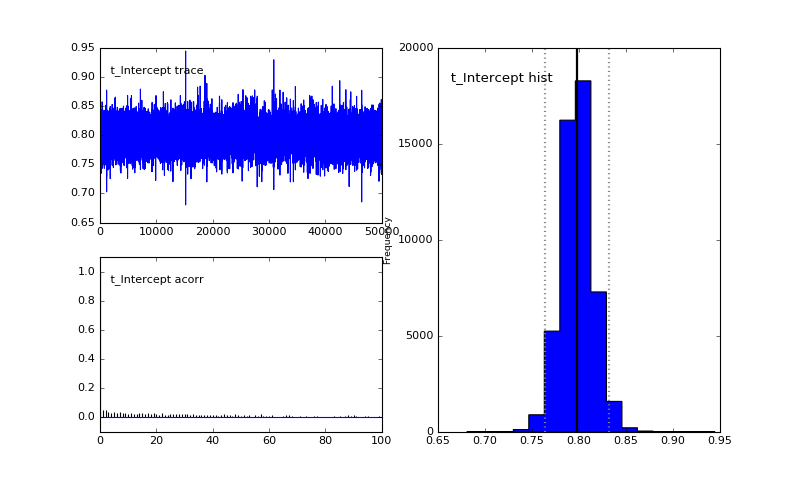

Plotting t_Intercept_std


<IPython.core.display.Javascript object>


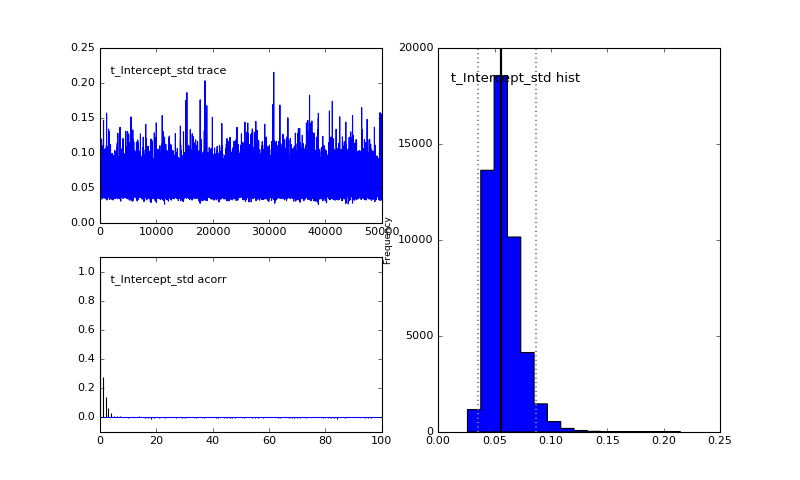

Exporting...


<IPython.core.display.Javascript object>


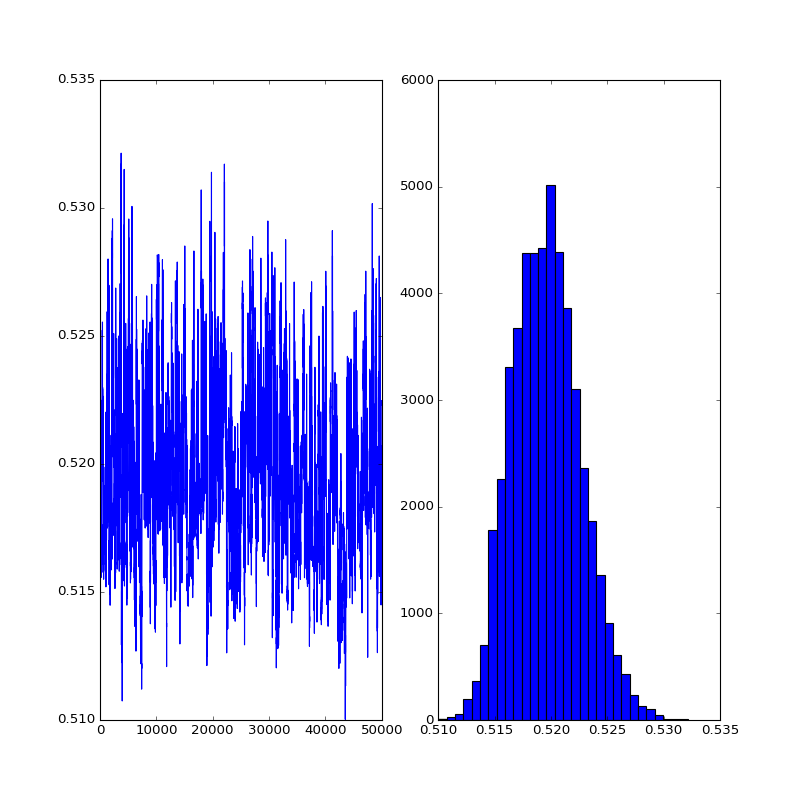

<IPython.core.display.Javascript object>


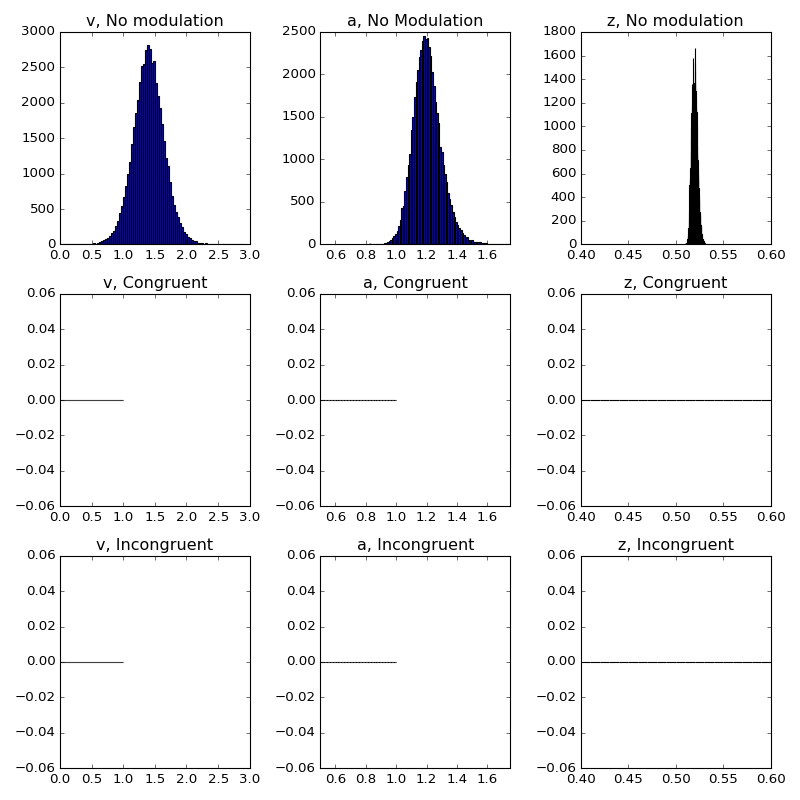

In [3]:
audio_null = plot_and_export_traces('audio', [])
plot_invlogit_z(audio_null)
plot_effects(audio_null)

## Visual, v ~ congruence, z ~ congruence, a ~ congruence

visual_all_accuracy_vC_zSC_aC_t/model_1.pkl
visual_all_accuracy_vC_zSC_aC_t/model_2.pkl
visual_all_accuracy_vC_zSC_aC_t/model_3.pkl
visual_all_accuracy_vC_zSC_aC_t/model_4.pkl
visual_all_accuracy_vC_zSC_aC_t/model_5.pkl
visual ['v', 'a', 'z'] dic:  6686.0310019
Plotting sv


/home/leonardv/virtualenvs/np/lib/python3.4/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


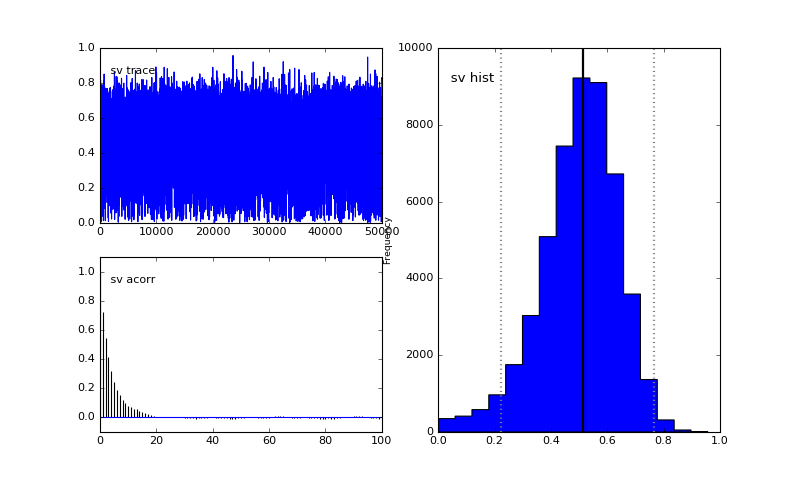

Plotting sz


<IPython.core.display.Javascript object>


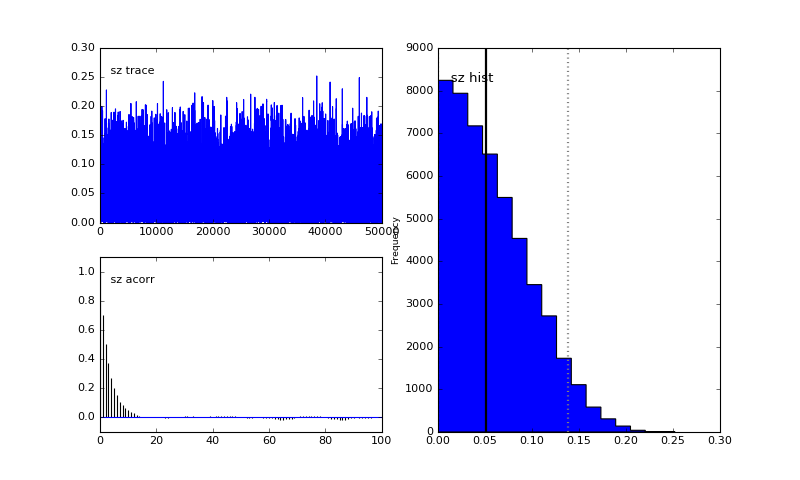

Plotting st


<IPython.core.display.Javascript object>


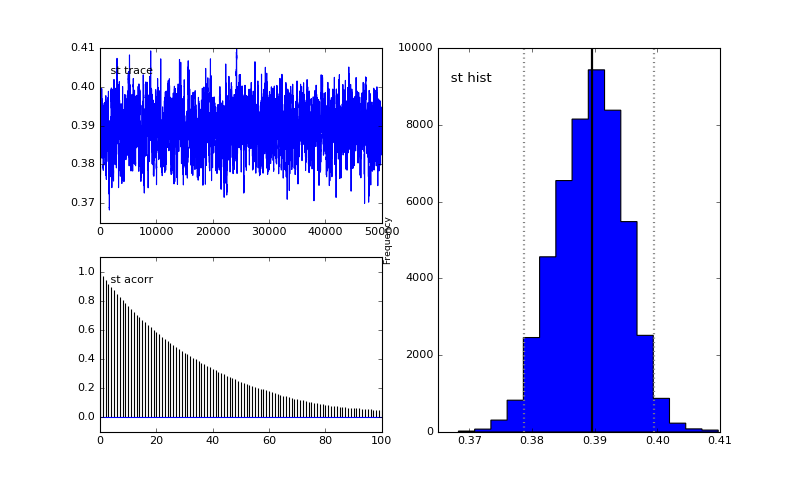

Plotting v_Intercept


<IPython.core.display.Javascript object>


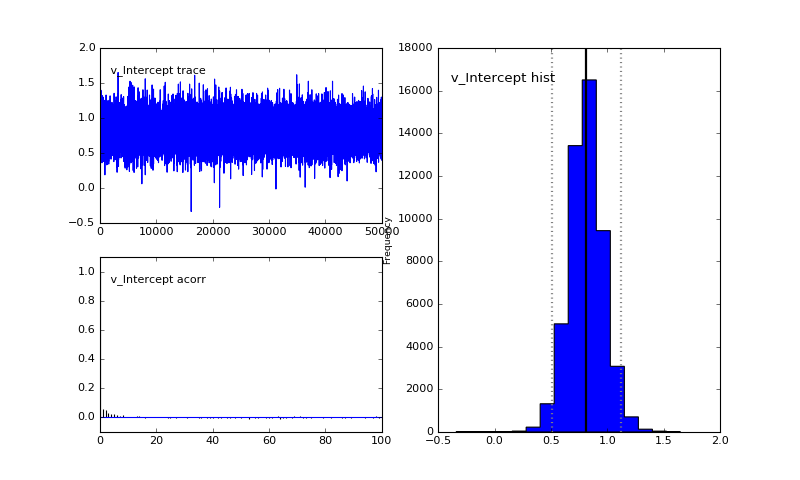

Plotting v_Intercept_std


<IPython.core.display.Javascript object>


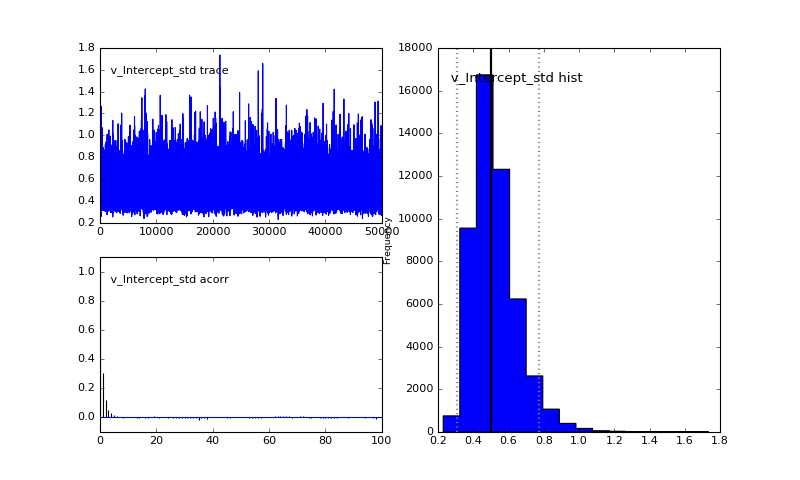

Plotting v_C(condition, Treatment("control"))[T.congruent]


<IPython.core.display.Javascript object>


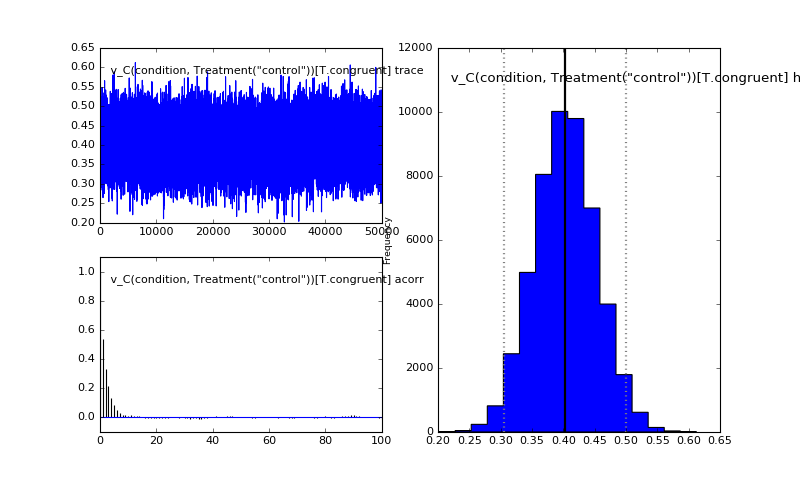

Plotting v_C(condition, Treatment("control"))[T.incongruent]


<IPython.core.display.Javascript object>


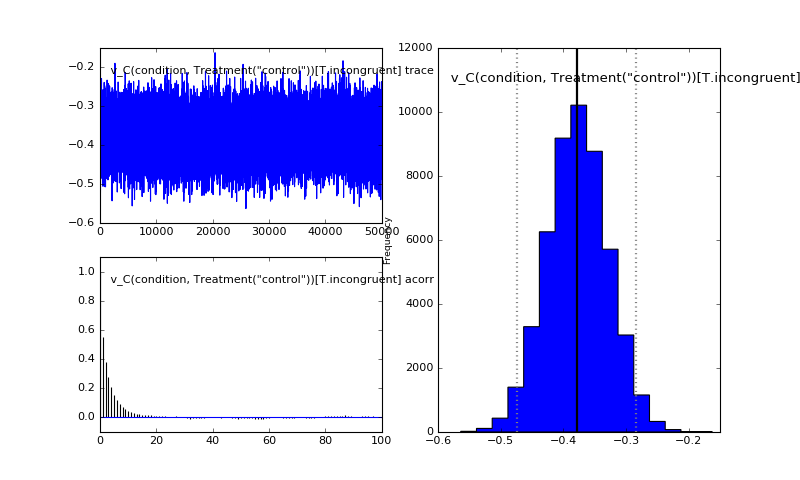

Plotting z_Intercept


<IPython.core.display.Javascript object>


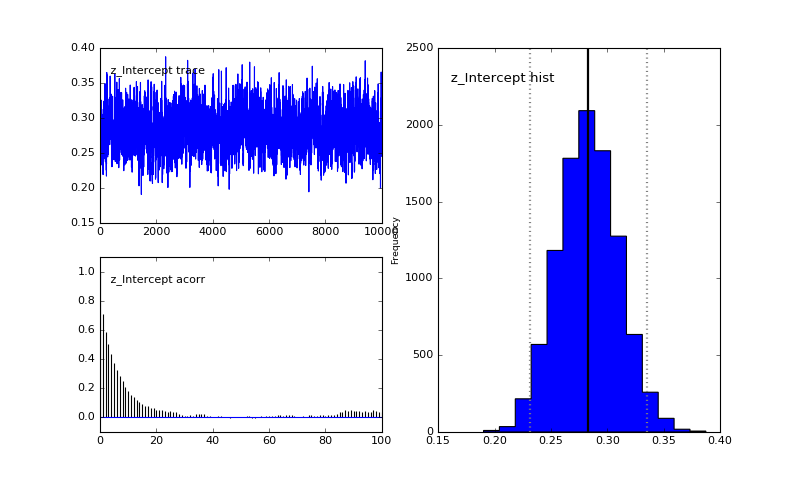

Plotting z_Intercept_std


<IPython.core.display.Javascript object>


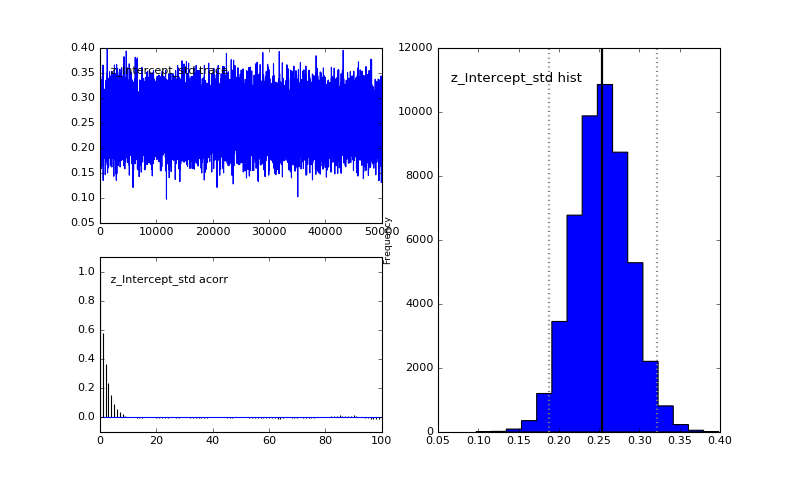

Plotting z_C(condition, Treatment("control"))[T.congruent]


<IPython.core.display.Javascript object>


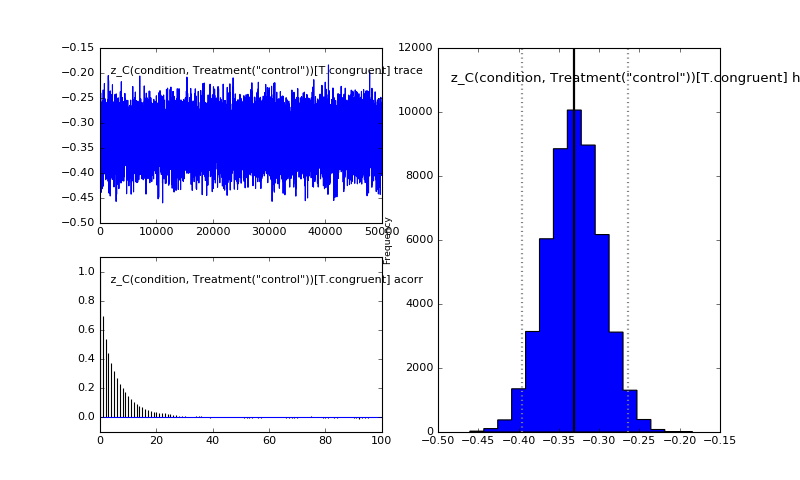

Plotting z_C(condition, Treatment("control"))[T.incongruent]


<IPython.core.display.Javascript object>


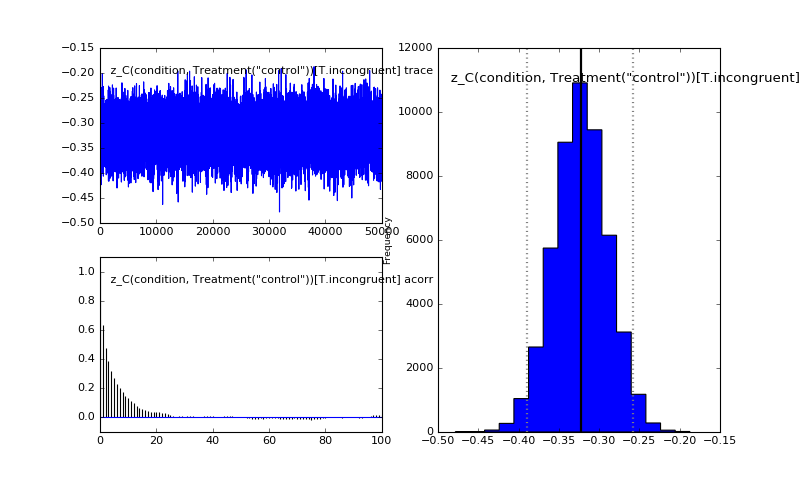

Plotting a_Intercept


<IPython.core.display.Javascript object>


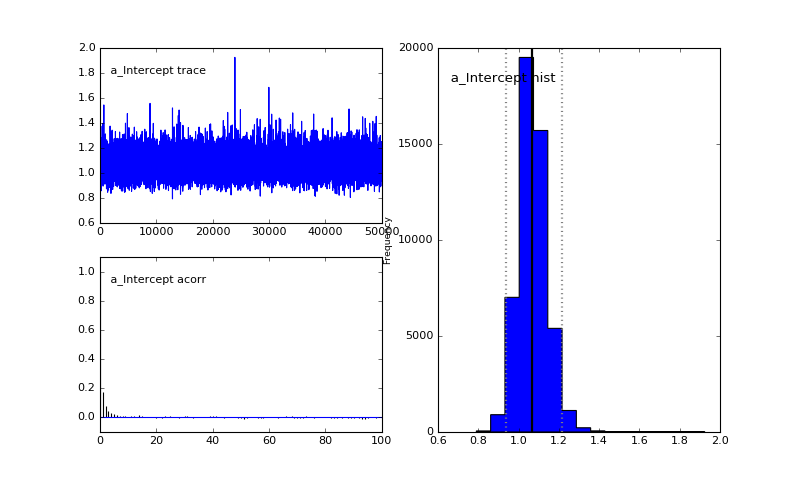

Plotting a_Intercept_std


<IPython.core.display.Javascript object>


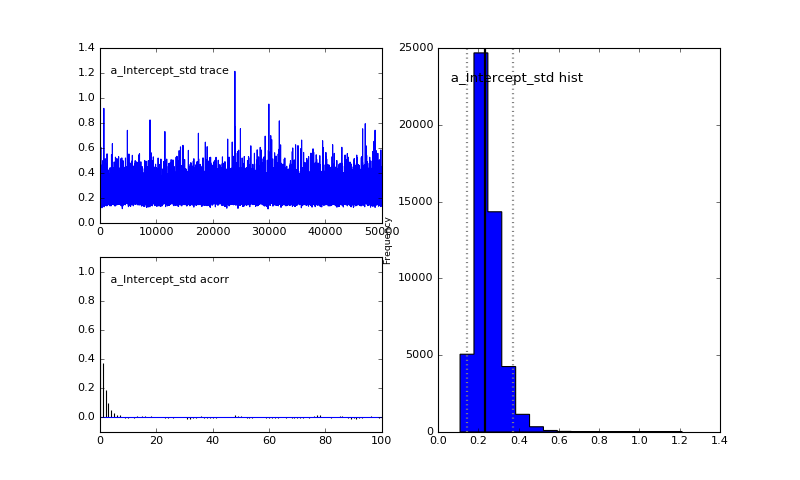

Plotting a_C(condition, Treatment("control"))[T.congruent]


<IPython.core.display.Javascript object>


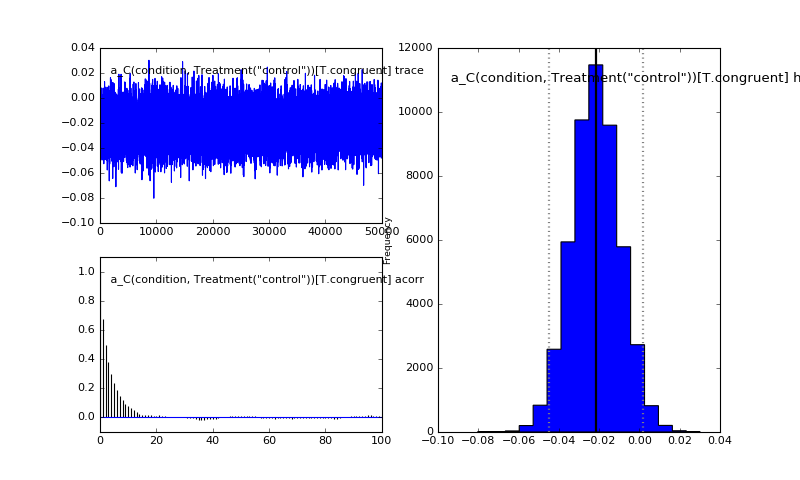

Plotting a_C(condition, Treatment("control"))[T.incongruent]


<IPython.core.display.Javascript object>


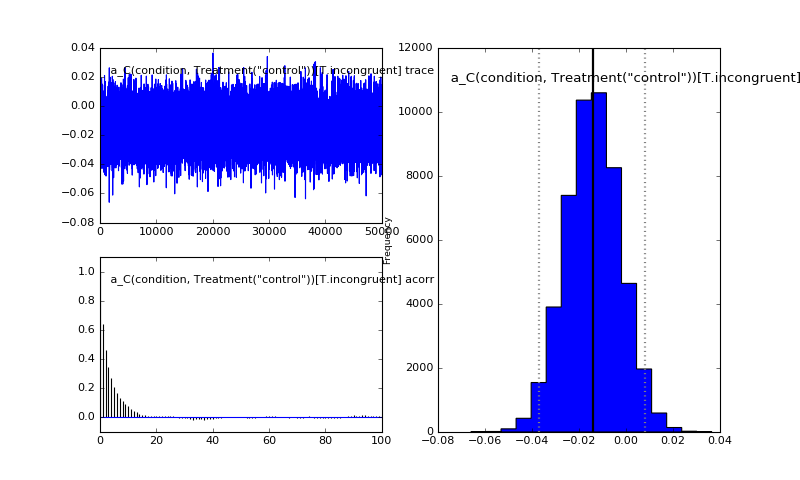

Plotting t_Intercept


<IPython.core.display.Javascript object>


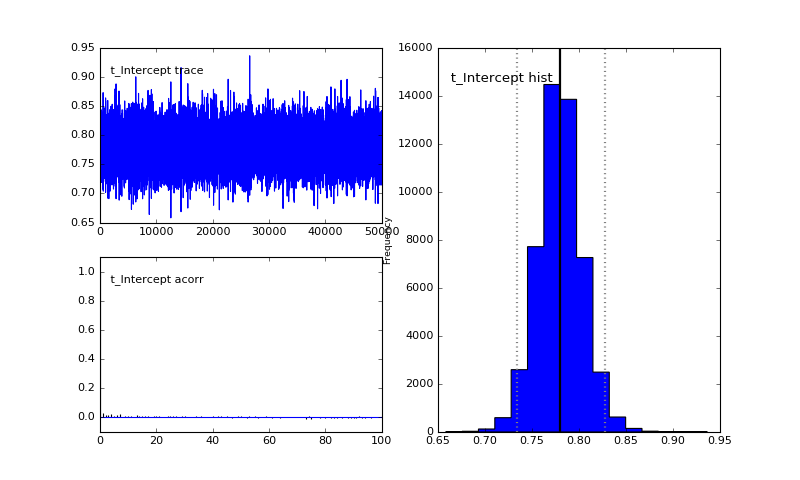

Plotting t_Intercept_std


<IPython.core.display.Javascript object>


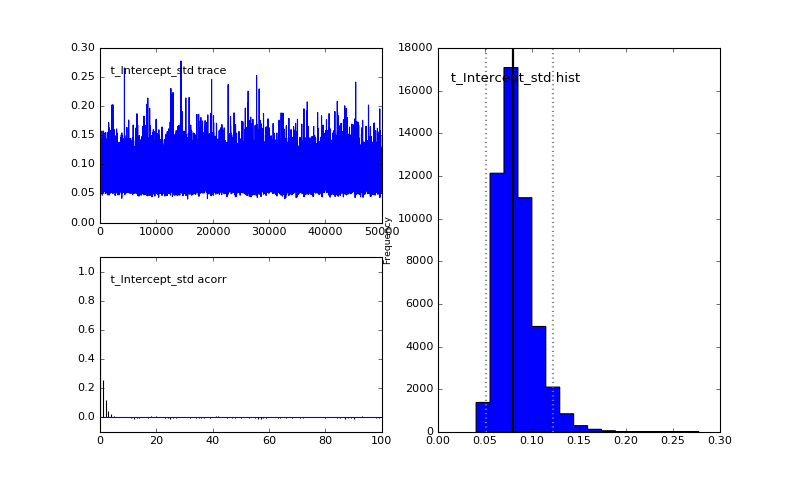

Exporting...


<IPython.core.display.Javascript object>


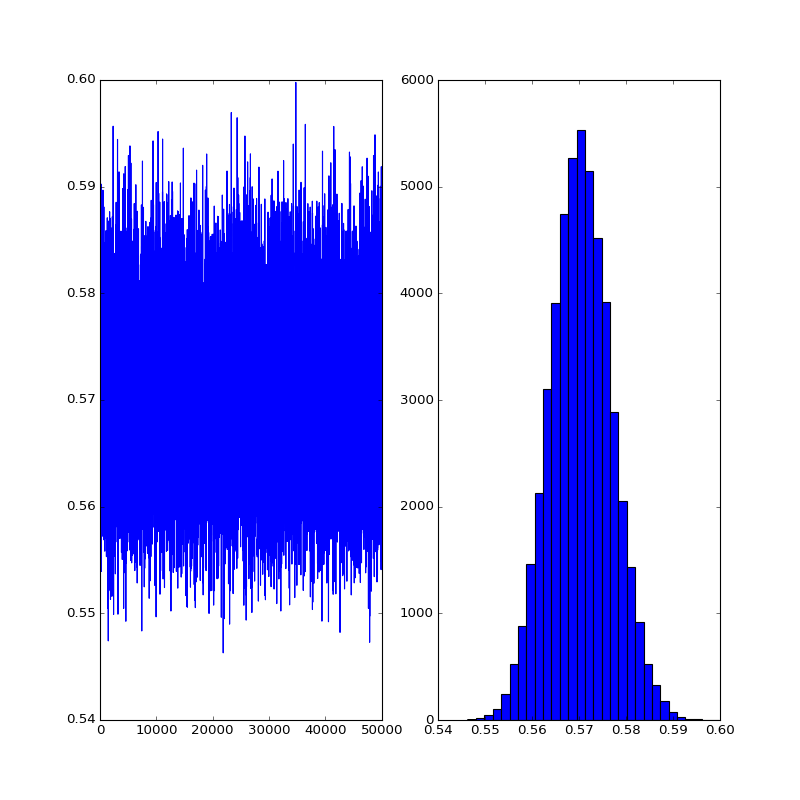

<IPython.core.display.Javascript object>


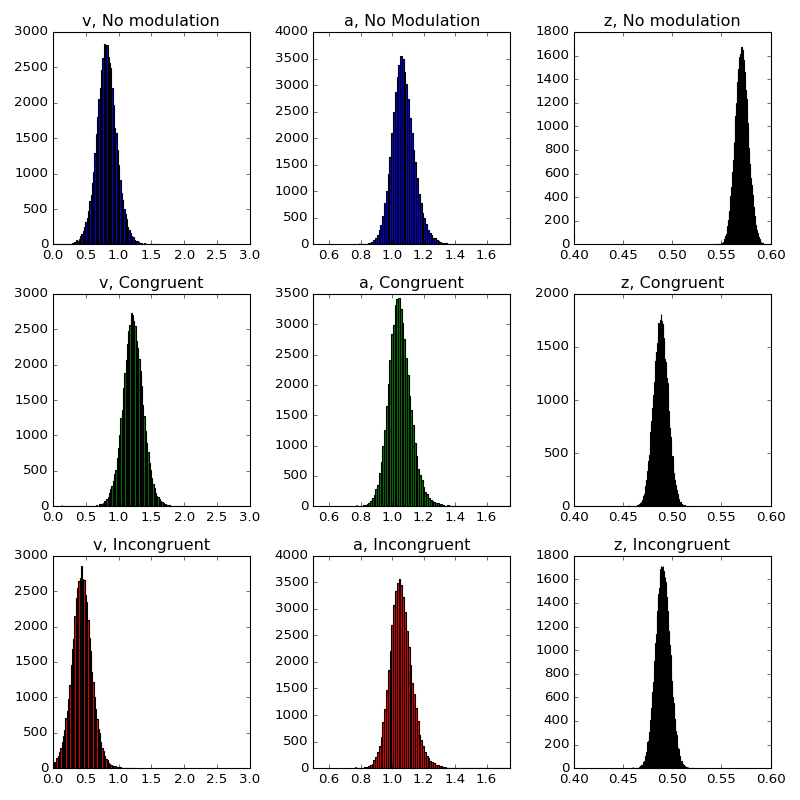

In [4]:
visual_v_a_z = plot_and_export_traces('visual', ['v', 'a', 'z'])
plot_invlogit_z(visual_v_a_z)
plot_effects(visual_v_a_z)

## Visual, no parameters dependent on congruence ("null") 

visual_all_accuracy_v_zS_a_t/model_1.pkl
visual_all_accuracy_v_zS_a_t/model_2.pkl
visual_all_accuracy_v_zS_a_t/model_3.pkl
visual_all_accuracy_v_zS_a_t/model_4.pkl
visual_all_accuracy_v_zS_a_t/model_5.pkl
visual [] dic:  8583.52090417
Plotting sv


/home/leonardv/virtualenvs/np/lib/python3.4/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


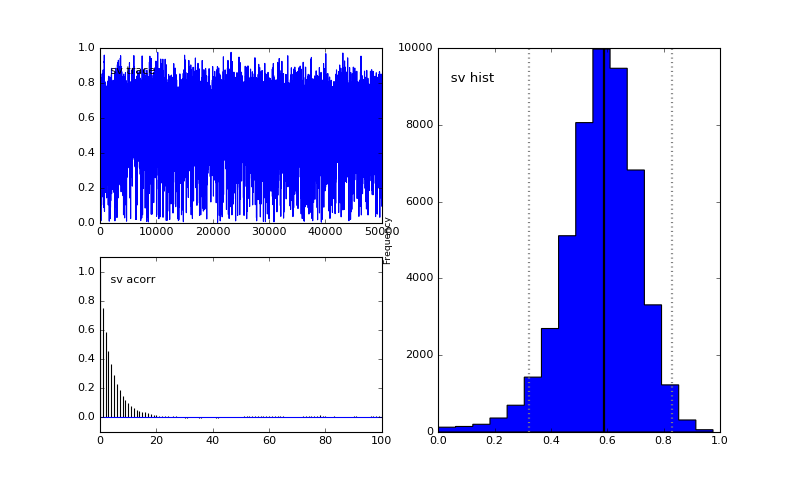

Plotting sz


<IPython.core.display.Javascript object>


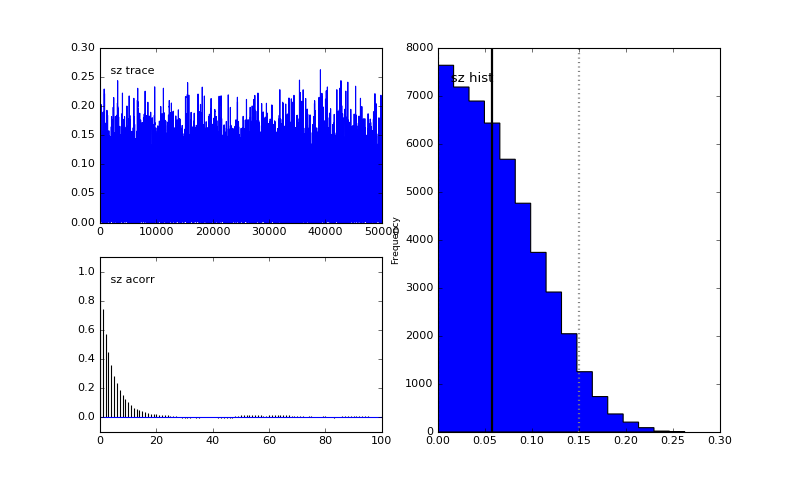

Plotting st


<IPython.core.display.Javascript object>


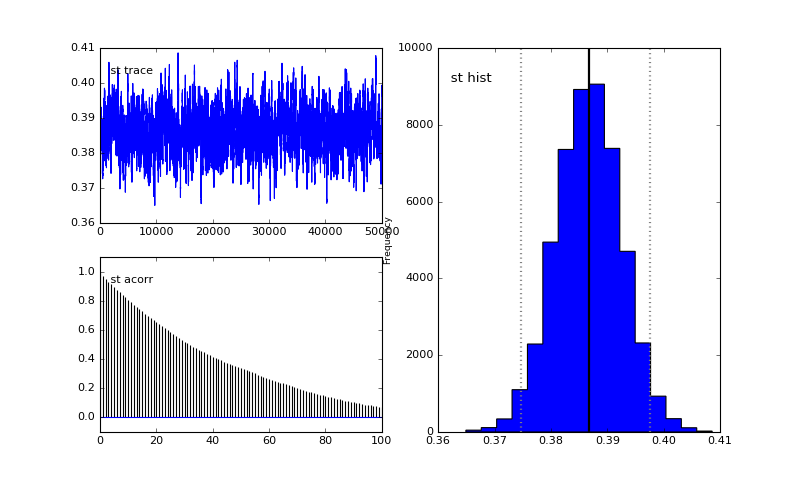

Plotting v_Intercept


<IPython.core.display.Javascript object>


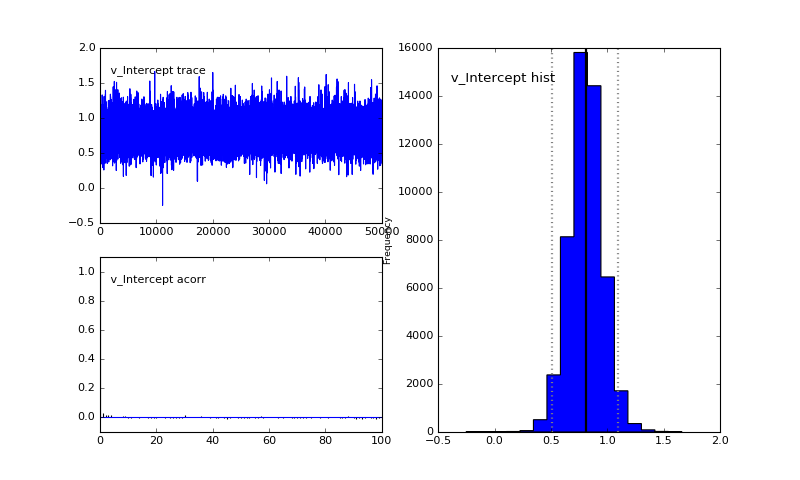

Plotting v_Intercept_std


<IPython.core.display.Javascript object>


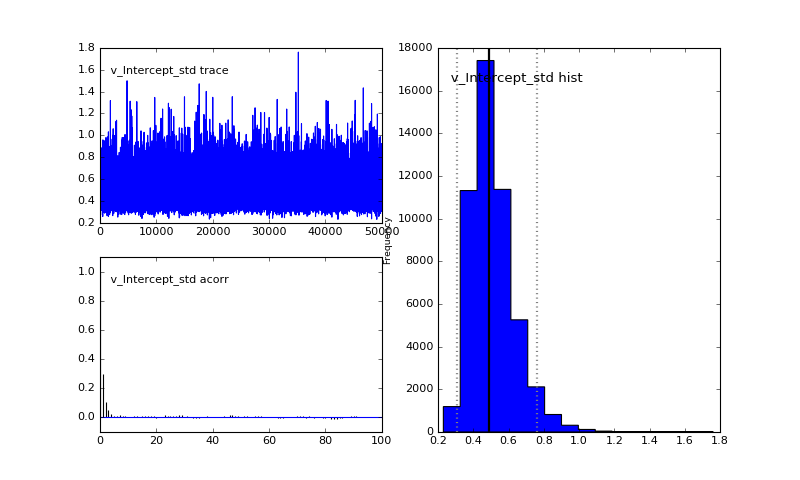

Plotting z_Intercept


<IPython.core.display.Javascript object>


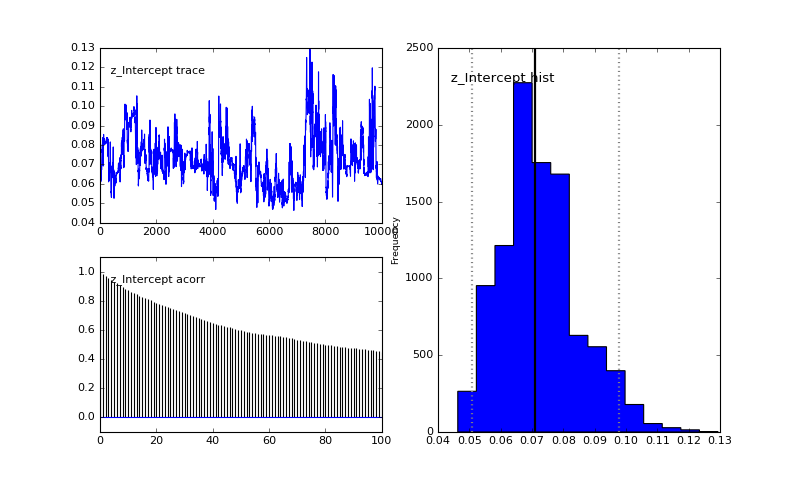

Plotting z_Intercept_std


<IPython.core.display.Javascript object>


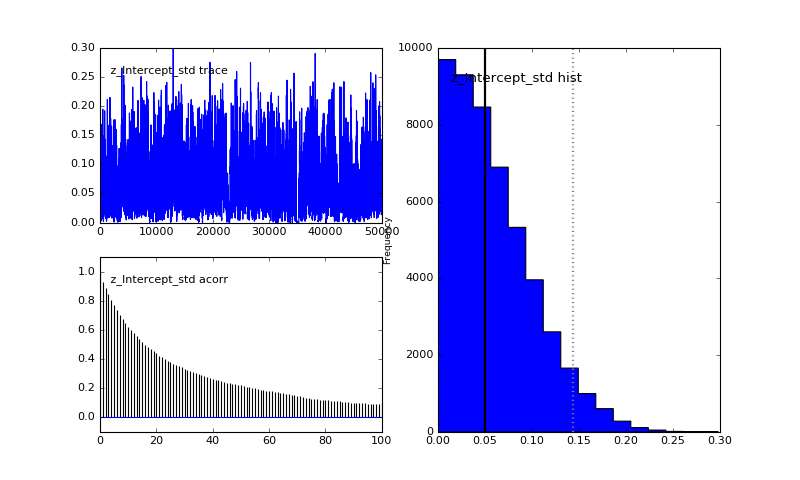

Plotting a_Intercept


<IPython.core.display.Javascript object>


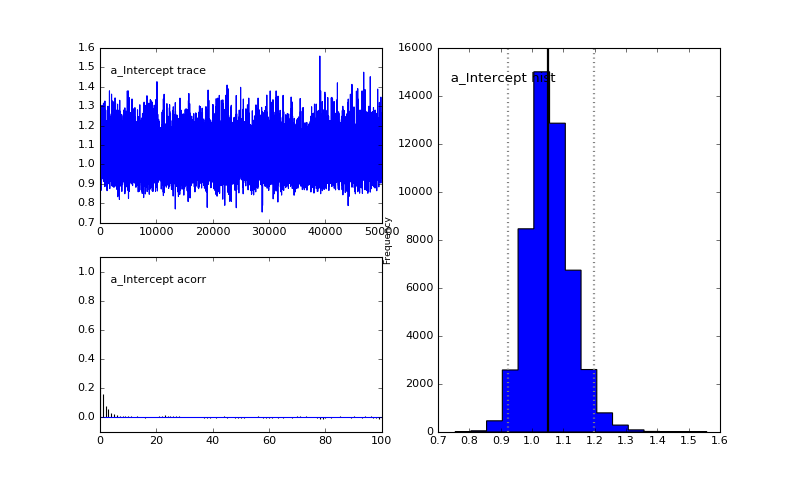

Plotting a_Intercept_std


<IPython.core.display.Javascript object>


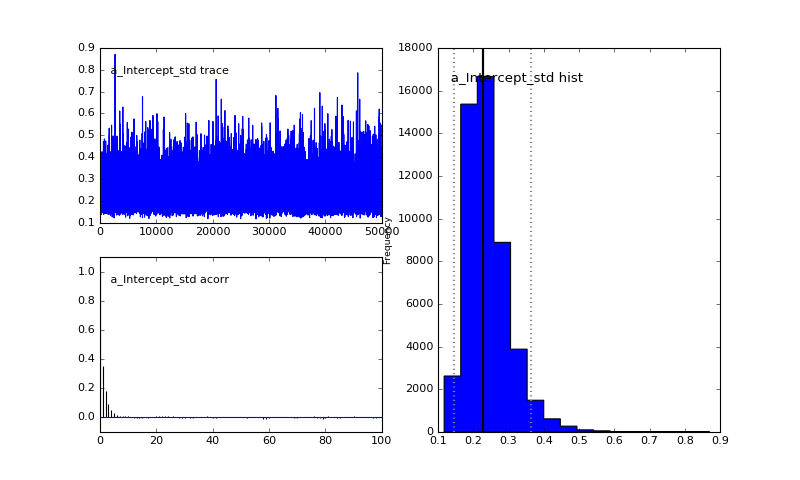

Plotting t_Intercept


<IPython.core.display.Javascript object>


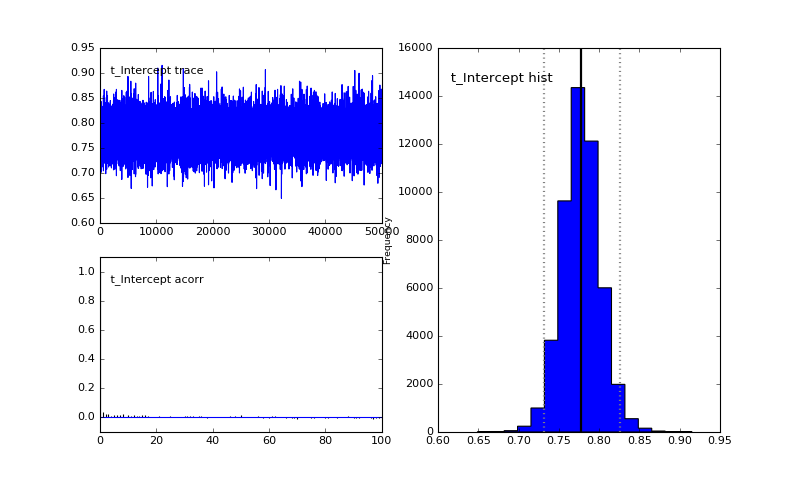

Plotting t_Intercept_std


<IPython.core.display.Javascript object>


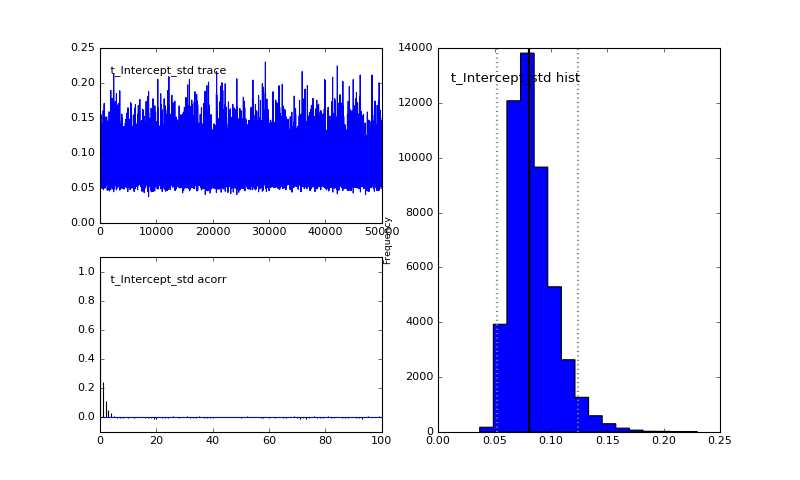

Exporting...


<IPython.core.display.Javascript object>


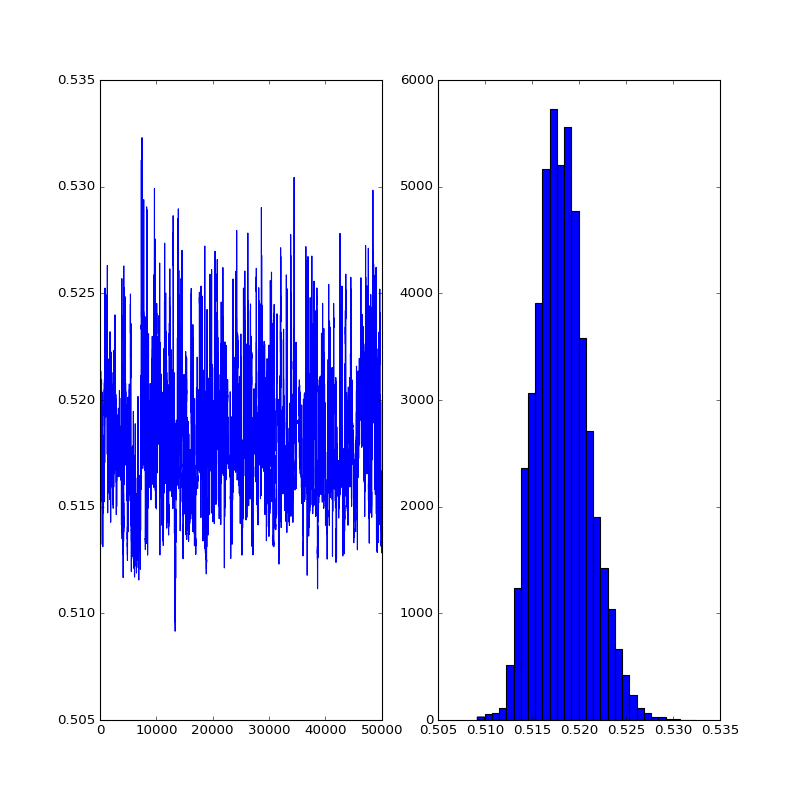

<IPython.core.display.Javascript object>


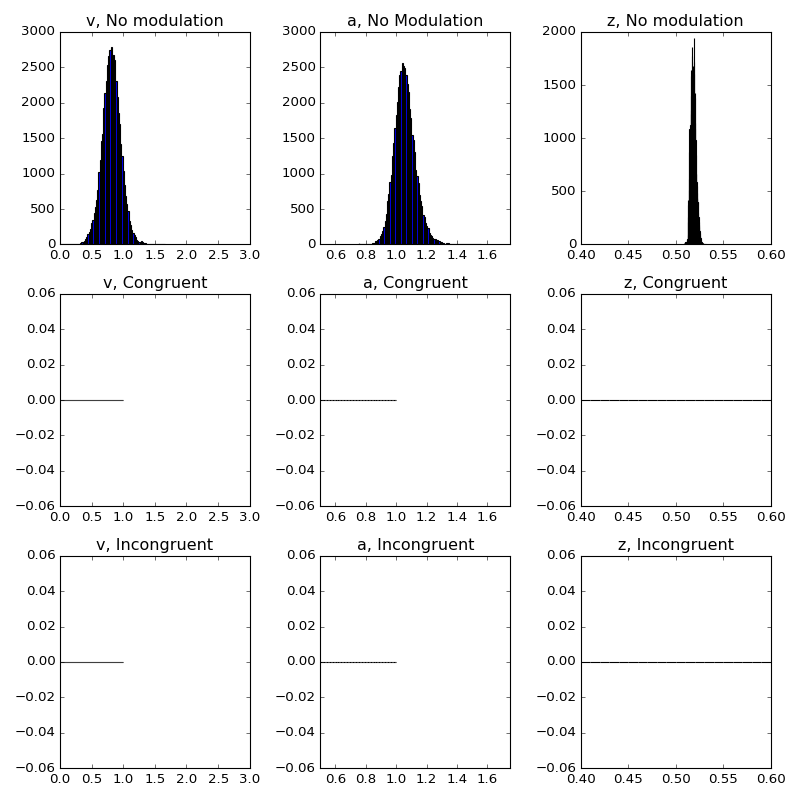

In [5]:
visual_null = plot_and_export_traces('visual', [])
plot_invlogit_z(visual_null)
plot_effects(visual_null)